# Dependencies

In [1]:
import mne, warnings # done in mac m1
import numpy as np # done in mac m1
from itertools import chain
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
import scipy.io
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler, DataLoader
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/tmp/ipykernel_991247/3661471088.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Functions & Classes

### Function: Feature extraction

In [2]:
def get_feature(data):
    channel_no = [0, 2, 16, 19] # only taking these four channels
    feature_matrix = []
    for ith_video in range(data.shape[0]):
        features = []
        for ith_channel in channel_no:
            # power spectral density
            psd, freqs = plt.psd(data[ith_video][ith_channel], Fs = 128)
            # get frequency bands mean power
            theta_mean = np.mean(psd[np.logical_and(freqs >= 4, freqs <= 7)])
            alpha_mean = np.mean(psd[np.logical_and(freqs >= 8, freqs <= 13)])
            beta_mean  = np.mean(psd[np.logical_and(freqs >= 13, freqs <= 30)])
            gamma_mean = np.mean(psd[np.logical_and(freqs >= 30, freqs <= 40)])
            features.append([theta_mean, alpha_mean, beta_mean, gamma_mean])
        # flatten the features i.e. transform it from 2D to 1D
        feature_matrix.append(np.array(list(chain.from_iterable(features))))
    return np.array(feature_matrix)

### Function: Class labels

In [3]:
def get_class_labels(labels, class_type):
    # encoding
    num_labels = labels.shape[0]
    emotion = np.ones(num_labels)
    if(class_type=='valence'):
        for i in range(0, num_labels):
            if labels[i][0]>=5:
                emotion[i] = 0
            else:
                emotion[i] = 1
    elif(class_type=='arousal'):
        for i in range(num_labels):
            if labels[i][1]>=5:
                emotion[i] = 0
            else:
                emotion[i] = 1
    else:
        for i in range(num_labels):
            if(labels[i][0]>=5 and labels[i][1] >=5): # HVHA
                emotion[i] = 0
            elif(labels[i][0]>=5 and labels[i][1]<5): #HVLA
                emotion[i] = 1
            elif(labels[i][0]<5 and labels[i][1]>=5): #LVHA
                emotion[i] = 2
            else: #LVLA
                emotion[i] = 3
    return emotion

### Function: Sliding Window

In [4]:
# Function to apply sliding window
def apply_sliding_window(data, window_size, overlap_size, sampling_rate):
    trials, channels, time_steps = data.shape
    window_size_in_samples = int(window_size * sampling_rate)
    overlap_size_in_samples = int(overlap_size * sampling_rate)

    new_time_steps = int((time_steps - window_size_in_samples) / overlap_size_in_samples) + 1

    # Initialize an empty array for the new data
    new_data = np.zeros((trials, channels, new_time_steps, window_size_in_samples))

    # Apply sliding window
    for trial in range(trials):
        for channel in range(channels):
            for i in range(new_time_steps):
                start_idx = i * overlap_size_in_samples
                end_idx = start_idx + window_size_in_samples
                new_data[trial, channel, i, :] = data[trial, channel, start_idx:end_idx]

    return new_data

### Class: DEAP dataset class

In [5]:
class DEAPDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

        # Standardize the data
        scaler = StandardScaler()
        self.features = scaler.fit_transform(features)

        assert self.features.shape[0] == self.labels.shape[0]

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):

        sample_features = self.features[idx]
        sample_labels = self.labels[idx]

        features = torch.tensor(sample_features, dtype=torch.float32).to(device)
        labels = torch.tensor(sample_labels, dtype=torch.float32).to(device)

        return features, labels

### Class: MLP model class

In [6]:
# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.batch_norm2 = nn.BatchNorm1d(num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        # x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.batch_norm2(x)
        x = self.softmax(x)
        return x

### Initialization of hyperparameters

In [7]:
# model-related parameters
batch_size = 12
learning_rate = 0.001
num_epochs = 100
hidden_size = 50
weight_decay = 0#1e-5

# data-related paramters
window_size = 10
overlap_size = 5

# Main Scripts Start from here

In [8]:
subject_no = 's01'
# read the data
dataset_path = '../data/deap/'
deap_dataset = scipy.io.loadmat(dataset_path + subject_no + '.mat')

In [9]:
# separate data and labels
data = np.array(deap_dataset['data']) # for current data
labels = np.array(deap_dataset['labels']) # for current labels
# remove 3sec pre baseline
data  = data[0:40,0:32,384:8064]

In [36]:
# Parameters
sampling_rate = 128

# Apply sliding window to EEG data
new_data = apply_sliding_window(data, window_size, overlap_size, sampling_rate)

# Print the shape of the resulting data
print("Original data shape:", data.shape)
print("Sliding window data shape:", new_data.shape)


Original data shape: (40, 32, 7680)
Sliding window data shape: (40, 32, 11, 1280)


In [37]:
# windowed_data = new_data.transpose(0, 2, 1, 3)
windowed_data = new_data.reshape(new_data.shape[0]* new_data.shape[2], new_data.shape[1], new_data.shape[3])
windowed_labels = np.repeat(labels, new_data.shape[2], axis=0)
print(f"Windowed data shape: {windowed_data.shape}")
print(f"Windowed labels shape: {windowed_labels.shape}")

Windowed data shape: (440, 32, 1280)
Windowed labels shape: (440, 4)


In [38]:
new_data[0, :, 0,0]

array([  4.05213   ,   3.05326186,   1.18607868,   1.24150632,
         0.44477828,   1.48224566,  -5.16597533,  -5.44357024,
        -7.58547927,  -4.69006138, -10.40727608,  -5.65112981,
        -9.99110654,  -5.8908037 ,  -1.84688635,  -0.66937296,
         4.8571618 ,   5.08835034,   2.78964412,   3.18963749,
         4.26230189,   3.22384615,   3.93998582,  -0.84154535,
         1.22076425,   4.64861703,   2.89293124,   0.32994684,
         1.05449672,   2.74540878,   2.81410777,   3.66600597])

In [39]:
data[0,:,0]

array([  4.05213   ,   3.05326186,   1.18607868,   1.24150632,
         0.44477828,   1.48224566,  -5.16597533,  -5.44357024,
        -7.58547927,  -4.69006138, -10.40727608,  -5.65112981,
        -9.99110654,  -5.8908037 ,  -1.84688635,  -0.66937296,
         4.8571618 ,   5.08835034,   2.78964412,   3.18963749,
         4.26230189,   3.22384615,   3.93998582,  -0.84154535,
         1.22076425,   4.64861703,   2.89293124,   0.32994684,
         1.05449672,   2.74540878,   2.81410777,   3.66600597])

In [40]:
windowed_data[0,:,0]

array([ 4.05213   , -1.96334966,  4.34449797, -1.47488688, -1.6845739 ,
        0.46758094, -6.96572237,  2.60053624, -0.96050485,  0.91040313,
       -3.39686375,  3.05326186, -0.79027532,  3.65577633, -5.16525828,
       -0.09196482,  0.01869017, -2.92876987,  3.5427748 , -0.88957208,
       -1.34761537, -2.29087971,  1.18607868, -0.7012143 ,  2.03966913,
       -5.91649286,  0.17408117, -3.85331419,  0.49949613,  4.14760167,
       -1.49053644, -0.60248353])

In [14]:
raw_matrix = windowed_data.reshape(windowed_data.shape[0], -1)
raw_matrix.shape
features = raw_matrix

Features shape: (440, 16)


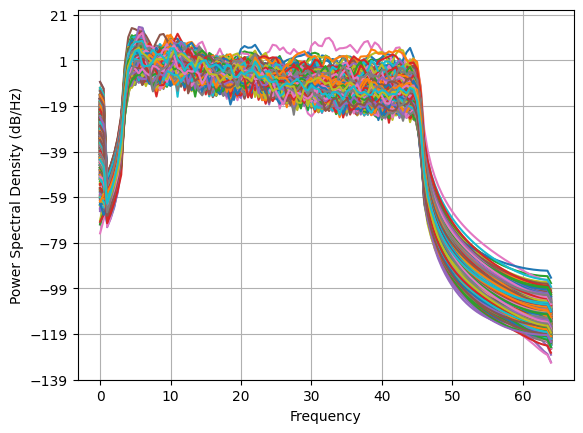

In [13]:
# channel_no = [0, 2, 16, 19] # only taking these four channels
# features = windowed_data[:,channel_no,:].reshape(windowed_data.shape[0], -1)
features = get_feature(windowed_data)
print(f"Features shape: {features.shape}")

In [15]:
# features = get_feature(data)
valence_labels = get_class_labels(windowed_labels, 'valence')
arousal_labels = get_class_labels(windowed_labels, 'arousal')
four_labels = get_class_labels(windowed_labels, 'four')
print(f"Labels shape: {four_labels.shape}")

Labels shape: (440,)


In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, four_labels, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (352, 40960)
Test shape: (88, 40960)


In [17]:
train_torch = DEAPDataset(X_train, y_train)

In [18]:
model = MLPClassifier(input_size=features.shape[1], hidden_size= hidden_size, num_classes=len(np.unique(four_labels)))
model.to(device)

MLPClassifier(
  (fc1): Linear(in_features=40960, out_features=50, bias=True)
  (batch_norm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=4, bias=True)
  (batch_norm2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)

# Train 
### - Don't Run this code except for training

In [25]:
k_folds = 10

kfold = KFold(n_splits=k_folds, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
val_losses = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_torch)):

    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    train_dataloader = DataLoader(train_torch, batch_size=batch_size, sampler=train_subsampler)
    val_dataloader = DataLoader(train_torch, batch_size=batch_size, sampler=val_subsampler)

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0.0
        train_correct_predictions = 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            train_loss = criterion(outputs, labels.long())
            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_correct_predictions += (predicted == labels).sum().item()


            with torch.no_grad():
                val_epoch_loss = 0.0
                for val_inputs, val_labels in val_dataloader:
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels.long())
                    val_epoch_loss += val_loss.item()


        average_train_loss = train_epoch_loss / len(train_dataloader.dataset)
        accuracy = train_correct_predictions / len(train_dataloader.dataset)
        train_losses.append(average_train_loss)

        average_val_loss = val_epoch_loss / len(val_dataloader.dataset)
        val_losses.append(average_val_loss)

    print(f'[{fold+1}] Fold => Train Loss: {average_train_loss:.4f}, Accuracy: {accuracy:.4f} | Validation Loss {average_val_loss:.4f}')


[1] Fold => Train Loss: 0.0874, Accuracy: 0.5795 | Validation Loss 0.0109
[2] Fold => Train Loss: 0.0786, Accuracy: 0.6761 | Validation Loss 0.0109
[3] Fold => Train Loss: 0.0763, Accuracy: 0.6960 | Validation Loss 0.0099
[4] Fold => Train Loss: 0.0748, Accuracy: 0.7045 | Validation Loss 0.0094
[5] Fold => Train Loss: 0.0736, Accuracy: 0.7188 | Validation Loss 0.0090
[6] Fold => Train Loss: 0.0736, Accuracy: 0.7074 | Validation Loss 0.0082
[7] Fold => Train Loss: 0.0723, Accuracy: 0.7188 | Validation Loss 0.0083
[8] Fold => Train Loss: 0.0720, Accuracy: 0.7216 | Validation Loss 0.0086
[9] Fold => Train Loss: 0.0728, Accuracy: 0.7074 | Validation Loss 0.0076
[10] Fold => Train Loss: 0.0720, Accuracy: 0.7131 | Validation Loss 0.0075


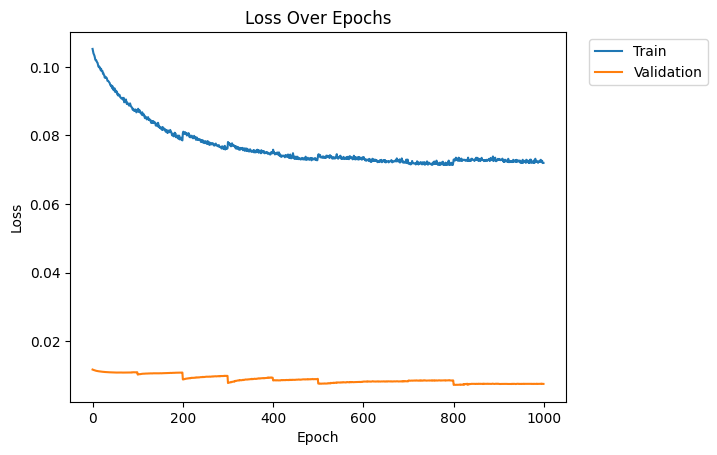

In [26]:
# Visualize the training loss graph
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [ ]:
# model_path = '../model/MLP.pt'
# torch.save(model, model_path)

# Test
### - Run after excution of all the functions and classes

In [26]:
model_path = './save/models/MLP_4-cls_10-folds.pt'
model = torch.load(model_path)

In [27]:
test_torch = DEAPDataset(X_test, y_test)
test_dataloader = DataLoader(test_torch, batch_size=1, shuffle=True)

In [28]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [29]:
# Evaluate on the test set
model.eval()
idx = 0
intermediate_features = []

model.softmax.register_forward_hook(get_activation('softmax'))

with torch.no_grad():
    correct_predictions = 0

    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        # print(test_outputs)
        _, predicted_labels = torch.max(test_outputs, 1)

        intermediate_features.append(activation['softmax'].cpu().numpy())

        print(f"Trial[{idx+1}] prediction: {int(predicted_labels)}, truth: {int(test_labels)}")
        idx += 1

        correct_predictions += (predicted_labels == test_labels).sum().item()

    test_accuracy = correct_predictions / len(test_dataloader.dataset)
    print(f'Test Accuracy: {test_accuracy:.4f}')

Trial[1] prediction: 3, truth: 2
Trial[2] prediction: 0, truth: 0
Trial[3] prediction: 3, truth: 2
Trial[4] prediction: 2, truth: 0
Trial[5] prediction: 2, truth: 3
Trial[6] prediction: 0, truth: 1
Trial[7] prediction: 1, truth: 3
Trial[8] prediction: 3, truth: 1
Trial[9] prediction: 3, truth: 2
Trial[10] prediction: 0, truth: 0
Trial[11] prediction: 0, truth: 3
Trial[12] prediction: 0, truth: 0
Trial[13] prediction: 3, truth: 0
Trial[14] prediction: 3, truth: 2
Trial[15] prediction: 0, truth: 0
Trial[16] prediction: 0, truth: 2
Trial[17] prediction: 2, truth: 3
Trial[18] prediction: 1, truth: 2
Trial[19] prediction: 2, truth: 0
Trial[20] prediction: 0, truth: 3
Trial[21] prediction: 2, truth: 1
Trial[22] prediction: 2, truth: 3
Trial[23] prediction: 2, truth: 0
Trial[24] prediction: 2, truth: 2
Trial[25] prediction: 3, truth: 0
Trial[26] prediction: 3, truth: 2
Trial[27] prediction: 0, truth: 0
Trial[28] prediction: 2, truth: 1
Trial[29] prediction: 0, truth: 2
Trial[30] prediction: 0

In [30]:
for i in range(len(intermediate_features)):
    print(f"Trial[{i+1}] {intermediate_features[i]}")

Trial[1] [[8.0149360e-03 1.0871556e-11 9.5756777e-14 9.9198508e-01]]
Trial[2] [[9.9999940e-01 2.1026288e-26 5.1254335e-07 7.4982701e-08]]
Trial[3] [[1.1988784e-02 9.8800194e-01 8.4522908e-06 7.9136532e-07]]
Trial[4] [[9.9136424e-01 1.3162934e-15 8.5631609e-03 7.2520066e-05]]
Trial[5] [[9.3836133e-11 9.9977368e-01 1.9147556e-04 3.4834724e-05]]
Trial[6] [[3.6766752e-09 2.1725371e-12 1.0000000e+00 8.8032373e-11]]
Trial[7] [[6.3134314e-05 7.4861143e-27 1.1929069e-03 9.9874395e-01]]
Trial[8] [[9.9999189e-01 4.9794685e-06 3.1461050e-06 3.6167230e-10]]
Trial[9] [[3.2296175e-01 9.9430654e-06 6.7702729e-01 1.0697889e-06]]
Trial[10] [[6.4902860e-25 9.8090893e-45 1.8543078e-23 1.0000000e+00]]
Trial[11] [[8.4582573e-01 1.1104987e-15 1.5768188e-03 1.5259750e-01]]
Trial[12] [[9.97657657e-01 1.52535461e-15 1.19238866e-04 2.22300109e-03]]
Trial[13] [[9.9831629e-01 4.8232278e-06 1.6695301e-03 9.3210547e-06]]
Trial[14] [[0.07561659 0.7908439  0.13097724 0.00256225]]
Trial[15] [[1.14128776e-01 1.89923684

In [35]:
import csv

# Specify the CSV file path
csv_file_path = '/save/features/feature_example.csv'

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV writer
    csvwriter = csv.writer(csvfile)

    # Iterate through each element in the list
    for element in intermediate_features:
        # Flatten the numpy array and convert to a list
        flattened_list = element.flatten().tolist()

        # Write the flattened list to the CSV file
        csvwriter.writerow(flattened_list)

print(f"The data has been saved to {csv_file_path}.")

The data has been saved to output.csv.


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 1. 기본 스타일 설정
# plt.style.use('default')
# plt.rcParams['figure.figsize'] = (5, 3)
# plt.rcParams['font.size'] = 12

# # 2. 데이터 준비
# np.random.seed(0)
# data_a = np.random.normal(6.8, 1, 10)
# data_b = np.random.normal(5.9, 1.5, 100)
# data_c = np.random.normal(3.3, 1.5, 100)
# data_d = np.random.normal(4, 1.5, 100)

# # 3. 그래프 그리기
# fig, ax = plt.subplots()

# ax.boxplot([data_a, data_b, data_c, data_d])
# ax.set_ylim(1.0, 9.0)
# ax.set_xlabel('Data Type')
# ax.set_ylabel('Likert-scale')
# ax.set_title('Q4 (HVLA)')
# ax.set_xticklabels(['MD-V', 'GM-V', 'MD-A', 'GM-A'])

# plt.show()

In [ ]:
# import muspy

# # Load a MIDI file using MusPy
# data_file_path = "../data/emopia/EMOPIA_1.0/midis/Q1__8v0MFBZoco_0.mid"
# target_file_path = "../midi/test9_emotion[1].mid"
# score = muspy.read_midi(target_file_path)

# # Extract Pitch Range
# pitch_range = muspy.pitch_range(score)

# # # Extract Number of Pitch Classes per Bar
# num_pitch_classes_per_bar = muspy.n_pitch_classes_used(score)

# # # Extract Polyphony
# polyphony = muspy.polyphony(score)

# # Print or use the extracted features
# print("Pitch Range:", pitch_range)
# print("Number of Pitch Classes per Bar:", num_pitch_classes_per_bar)
# print("Polyphony:", polyphony)


In [41]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


In [46]:
data = []
labels = []
for i in files: 
    filename = "../data/deap/s" + i + ".mat"
    deap_data = scipy.io.loadmat(filename)
    # separate data and labels
    data.append(np.array(deap_data['data'])) # for current data
    labels.append(np.array(deap_data['labels'])) # for current labels


In [48]:
data = np.array(data)
labels = np.array(labels)

In [58]:
# Parameters
sampling_rate = 128
windowed_data = []
windowed_labels = []
channel_no = [0, 2, 16, 19]

for i in range(len(files)):
    new_data = data[i, :, :, 384:8064]
    # Apply sliding window to EEG data
    new_data = apply_sliding_window(new_data, window_size, overlap_size, sampling_rate)
    # windowed_data = new_data.transpose(0, 2, 1, 3)
    windowed_data.append(new_data.reshape(new_data.shape[0]* new_data.shape[2], new_data.shape[1], new_data.shape[3]))
    windowed_labels.append(np.repeat(labels[i], new_data.shape[2], axis=0))

windowed_data = np.take(np.array(windowed_data), channel_no, axis=2)
windowed_labels = np.array(windowed_labels)

        

In [62]:
print(windowed_data[:, ])
print(windowed_labels.shape)

(22, 440, 4, 1280)
(22, 440, 4)
